# Causal Inference

Author: Adrian Alarcon

## About

This project wants to use **causal inference** techniques to identify the impact of many variables in the price of a soccer player. Actually, this is a very polemic topic with many controversial opinions. Some people think that there are a difference between right footed players and left footed players, since they say that left footed players are more expensive than right footed players.

In [168]:
## Loading libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split


from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.tf import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset.regression import *
from causalml.metrics import *

import seaborn as sns
import warnings

sns.set_theme(style='ticks')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## Data preprocessing

### Read data

In [203]:
data_path = 'https://raw.githubusercontent.com/aladelca/enterprise_data_science/main/data_extract/players_all.csv'
data = pd.read_csv(data_path, index_col=0)
print(data.shape)
data.head()

(5100, 78)


,name,Age,Overall rating,Potential,Team & Contract,ID,Height,Weight,foot,Best overall,Best position,Growth,Joined,Loan date end,Value,Wage,Release clause,Total attacking,Crossing,Finishing,Heading accuracy,Short passing,Volleys,Total skill,Dribbling,Curve,FK Accuracy,Long passing,Ball control,Total movement,Acceleration,Sprint speed,Agility,Reactions,Balance,Total power,Shot power,Jumping,Stamina,Strength,Long shots,Total mentality,Aggression,Interceptions,Att. Position,Vision,Penalties,Composure,Total defending,Defensive awareness,Standing tackle,Sliding tackle,Total goalkeeping,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Total stats,Base stats,Weak foot,Skill moves,Attacking work rate,Defensive work rate,International reputation,Body type,Real face,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defending / Pace,Physical / Positioning,Traits,PlayStyles,PlayStyles +,Number of playstyles,Unnamed: 78
0,Vini Jr. LW ST,22,89,94,Real Madrid\n2018 ~ 2027,238794,"176cm / 5'9""",73kg / 161lbs,Right,89,LW,5,"Jul 12, 2018",NaN,€158.5M,€310K,€336.8M,369,78,89,50,80,72,398,92,77,62,77,90,454,95,95,94,86,84,378,76,74,84,64,80,317,58,26,87,81,65,79,75,32,25,18,36,5,7,7,7,10,2027,442,4,5,High,High,5,Lean (170-185),Yes,95,82,78,90,29,68,NaN,Finesse Shot Chip Shot Rapid Flair First Touch...,Quick Step +,7,NaN
1,A. Lunin GK,24,76+2,83+2,Real Madrid\n2018 ~ 2024,243952,"191cm / 6'3""",83kg / 183lbs,Right,76,GK,7,"Jul 2, 2018",NaN,€13M,€67K,€29.3M,72,15,8,12,25,12,81,11,14,15,26,15,210,39,35,36,75+2,25,217,56+2,61+1,32,61,7,131,22,19,11,60,19,56,46,22,13,11,375,76+2,73+2,74+2,75+2,77+2,1132,412,3,1,Medium,Medium,1,Normal (185+),Yes,76,73,74,77,37,75,NaN,Footwork Rush Out,NaN,2,NaN
2,J. Bellingham CAM CM,20,87,92,Real Madrid\n2023 ~ 2029,252371,"186cm / 6'1""",75kg / 165lbs,Right,89,CAM,5,"Jul 1, 2023",NaN,€118.5M,€190K,€251.8M,383,66,86,69,88,74,388,87,73,56,86,86,402,78,76,81,88,79,407,79,80,93,75,80,404,85,82,87,86,64,85,233,77,79,77,48,14,11,10,5,8,2265,486,4,4,High,High,4,Lean (185+),Yes,77,82,81,86,78,82,NaN,Intercept Slide Tackle Technical Flair,Relentless +,5,NaN
3,R. Højlund ST,20,77,89,Manchester United\n2023 ~ 2028,259399,"191cm / 6'3""",79kg / 174lbs,Left,79,ST,12,"Aug 5, 2023",NaN,€25.5M,€77K,€53.6M,325,38,78,70,71+1,68,306,76+1,58,48,49,75-1,380,84,86,69,78+3,63,403,82+4,88,78+3,85,70,322,82+2,28,79+1,63+5,70,75+3,79,32+5,28,19,50,12,8,9,14,7,1865,409,3,3,Medium,High,1,Normal (185+),No,85,76,58,74,33,83,NaN,Rapid Flair Quick Step,NaN,3,NaN
4,K. Havertz CAM RW ST,24,82,87,Arsenal\n2023 ~ 2028,235790,"190cm / 6'3""",82kg / 181lbs,Left,85,CAM,5,"Jun 28, 2023",NaN,€46M,€110K,€88.6M,398,74,81,80,83,80,385,84,84,53,79,85,382,75,81,75,83,68,382,76,82,77,69,78,327,52,38,83,81,73,84,123,39,46,38,47,6,8,11,10,12,2044,432,4,4,Medium,Medium,3,Unique,Yes,78,79,79,83,45,68,NaN,Chip Shot Technical First Touch Trivela,NaN,4,NaN


### Data cleaning

In [204]:
## Constants
FINAL_COLUMNS = [
    'foot',
    'Best position',
    'Defensive work rate',
    'Body type',
    'Traits',
    'PlayStyles',
    'PlayStyles +',
    'club',
    'loan',
    'Age',
    #'wage_euros',
    #'release_clause_euros',
    'Best overall',
    'Growth',
    'Total attacking',
    'Total skill',
    'Total movement',
    'Total power',
    'Total mentality',
    'Total defending',
    'Total goalkeeping',
    'Total stats',
    'Base stats',
    #'Weak foot',
    'Skill moves',
    'International reputation',
    'Pace / Diving',
    'Shooting / Handling',
    'Dribbling / Reflexes',
    'Defending / Pace',
    'Physical / Positioning',
    'Number of playstyles',
    'height_cm',
    'weight_kg',
    'total_potential',
    'contract_duration_years',
    'contract_years_left',
    'total_crossing',
    'total_finishing',
    'total_heading_accuracy',
    'total_short_passing',
    'total_volleys',
    'total_dribbling',
    'total_curve',
    'total_fk_accuracy',
    'total_long_passing',
    'total_ball_control',
    'total_acceleration',
    'total_sprint_speed',
    'total_agility',
    'total_reactions',
    'total_balance',
    'total_shot_power',
    'total_jumping',
    'total_stamina',
    'total_strength',
    'total_long_shots',
    'total_aggression',
    'total_interceptions',
    'total_att__position',
    'total_vision',
    'total_penalties',
    'total_composure',
    'total_defensive_awareness',
    'total_standing_tackle',
    'total_gk_diving',
    'total_gk_handling',
    'total_gk_positioning',
    'total_gk_reflexes',
    'total_overall_rating'
]

columns = [
    'Crossing',
    'Potential',
    'Finishing',
    'Heading accuracy',
    'Short passing',
    'Volleys',
    'Dribbling',
    'Curve',
    'FK Accuracy',
    'Long passing',
    'Ball control',
    'Acceleration',
    'Sprint speed',
    'Agility',
    'Reactions',
    'Balance',
    'Shot power',
    'Jumping',
    'Stamina',
    'Strength',
    'Long shots',
    'Aggression',
    'Interceptions',
    'Att. Position',
    'Vision',
    'Penalties',
    'Composure',
    'Defensive awareness',
    'Standing tackle',
    'GK Diving',
    'GK Handling',
    'GK Kicking',
    'GK Positioning',
    'GK Reflexes',
    'Overall rating'
]

TARGET = [
    'value_euros',
    ]
CAT_VARIABLES = [
    'foot',
    'Best position',
    'Defensive work rate',
    'Body type',
    'Traits',
    'PlayStyles',
    'PlayStyles +',
    'club',
    'loan'
]

NUM_VARIABLES = list(set(FINAL_COLUMNS) - set(CAT_VARIABLES))
index_cat_variables = [FINAL_COLUMNS.index(var) for var in CAT_VARIABLES if var in FINAL_COLUMNS]


In [205]:
### Data cleaning

def get_height(data):
    df_height = data['Height'].str.split('/', expand=True)
    df_height.columns = ['height_cm','height_inch']
    data['height_cm'] = df_height['height_cm'].str.replace('cm','')
    data['height_cm'] = data['height_cm'].astype(int) 
    return data

def get_weight(data):
    df_weight = data['Weight'].str.split('/', expand=True)
    df_weight.columns = ['weight_kg','height_lbs']
    data['weight_kg'] = df_weight['weight_kg'].str.replace('kg','')
    data['weight_kg'] = data['weight_kg'].astype(int) 
    return data

def extract_year(string):
    try:
        match = re.search(r'\b\d{4}\b', string)
        year_extracted = match.group()
        return year_extracted
    except:
        return string

def manage_currency(column_name,final_column_name, data):
    data[column_name] = data[column_name].str.replace('€','')
    data['factor'] = np.where(data[column_name].str.contains('M'),1000000, np.where(data[column_name].str.contains('K'),1000,1))
    data[column_name] = data[column_name].str.replace('M','')
    data[column_name] = data[column_name].str.replace('K','')
    data[column_name] = data[column_name].astype(float)
    data[final_column_name] = data['factor'] * data[column_name]
    return data

def fill_columns(column_name, new_column_name, data):

    df_potential = data[column_name].str.split('[-,+]', expand=True).fillna(0).astype(int)
    data[new_column_name] = df_potential[0] + df_potential[1]
    return data

def get_contract_team_variables(current_year,data):
    df_club = data['Team & Contract'].str.split('\n', expand = True)
    df_club.columns = ['club','contract']
    data['club'] = df_club['club']
    data['loan'] = df_club['contract'].str.contains('On loan')
    df_club['contract_end'] = df_club['contract'].apply(lambda x: extract_year(x) if 'On loan' in x else x)
    df_contract = df_club['contract_end'].str.split('~', expand = True)
    df_contract.columns = ['start','end']
    df_contract['end'] = np.where(df_contract['end'].isna(),df_contract['start'], df_contract['end'])
    data['contract_end'] = df_contract['end']
    data['contract_start'] = data['Joined'].apply(lambda x: extract_year(x))
    data['contract_end'] = data['contract_end'].str.strip()
    data['contract_end'] = np.where(data['contract_end'] == 'Free','', data['contract_end'])
    data['contract_end'] = data['contract_end'].replace('',np.nan)
    data['contract_end'] = data['contract_end'].astype(float)
    data['contract_duration_years'] = data['contract_end'] - data['contract_start'].astype(float)
    data['contract_years_left'] = np.where(data['contract_end'] - 2024>=0, data['contract_end'] - current_year, np.nan)
    return data

def get_total_values(data, columns):
    for i in columns:
        new_column = 'total_'+i.lower()
        new_column = new_column.replace(' ','_')
        new_column = new_column.replace('.','_')
        data = fill_columns(i,new_column,data)
    return data

def get_final_columns(data, columns):
    data = data[columns]
    return data

def data_preprocess(data):
    
    data = get_height(data)
    data = get_weight(data)
    data = manage_currency('Value','value_euros',data)
    data = manage_currency('Wage','wage_euros',data)
    data = manage_currency('Release clause','release_clause_euros',data)
    data = get_contract_team_variables(2024, data)
    data = get_total_values(data, columns)
    data = get_final_columns(data,FINAL_COLUMNS + TARGET)
    return data



In [206]:
df = data_preprocess(data)
df.head()

,foot,Best position,Defensive work rate,Body type,Traits,PlayStyles,PlayStyles +,club,loan,Age,Best overall,Growth,Total attacking,Total skill,Total movement,Total power,Total mentality,Total defending,Total goalkeeping,Total stats,Base stats,Skill moves,International reputation,Pace / Diving,Shooting / Handling,Dribbling / Reflexes,Defending / Pace,Physical / Positioning,Number of playstyles,height_cm,weight_kg,total_potential,contract_duration_years,contract_years_left,total_crossing,total_finishing,total_heading_accuracy,total_short_passing,total_volleys,total_dribbling,total_curve,total_fk_accuracy,total_long_passing,total_ball_control,total_acceleration,total_sprint_speed,total_agility,total_reactions,total_balance,total_shot_power,total_jumping,total_stamina,total_strength,total_long_shots,total_aggression,total_interceptions,total_att__position,total_vision,total_penalties,total_composure,total_defensive_awareness,total_standing_tackle,total_gk_diving,total_gk_handling,total_gk_positioning,total_gk_reflexes,total_overall_rating,value_euros
0,Right,LW,High,Lean (170-185),NaN,Finesse Shot Chip Shot Rapid Flair First Touch...,Quick Step +,Real Madrid,False,22,89,5,369,398,454,378,317,75,36,2027,442,5,5,95,82,90,29,68,7,176,73,94,9.0,3.0,78,89,50,80,72,92,77,62,77,90,95,95,94,86,84,76,74,84,64,80,58,26,87,81,65,79,32,25,5,7,7,10,89,158500000.0
1,Right,GK,Medium,Normal (185+),NaN,Footwork Rush Out,NaN,Real Madrid,False,24,76,7,72,81,210,217,131,46,375,1132,412,1,1,76,73,77,37,75,2,191,83,85,6.0,0.0,15,8,12,25,12,11,14,15,26,15,39,35,36,77,25,58,62,32,61,7,22,19,11,60,19,56,22,13,78,75,77,79,78,13000000.0
2,Right,CAM,High,Lean (185+),NaN,Intercept Slide Tackle Technical Flair,Relentless +,Real Madrid,False,20,89,5,383,388,402,407,404,233,48,2265,486,4,4,77,82,86,78,82,5,186,75,92,6.0,5.0,66,86,69,88,74,87,73,56,86,86,78,76,81,88,79,79,80,93,75,80,85,82,87,86,64,85,77,79,14,11,5,8,87,118500000.0
3,Left,ST,High,Normal (185+),NaN,Rapid Flair Quick Step,NaN,Manchester United,False,20,79,12,325,306,380,403,322,79,50,1865,409,3,1,85,76,74,33,83,3,191,79,89,5.0,4.0,38,78,70,72,68,77,58,48,49,76,84,86,69,81,63,86,88,81,85,70,84,28,80,68,70,78,37,28,12,8,14,7,77,25500000.0
4,Left,CAM,Medium,Unique,NaN,Chip Shot Technical First Touch Trivela,NaN,Arsenal,False,24,85,5,398,385,382,382,327,123,47,2044,432,4,3,78,79,83,45,68,4,190,82,87,5.0,4.0,74,81,80,83,80,84,84,53,79,85,75,81,75,83,68,76,82,77,69,78,52,38,83,81,73,84,39,46,6,8,10,12,82,46000000.0


(5100, 68)


<Axes: title={'center': 'Percentage of null values'}>

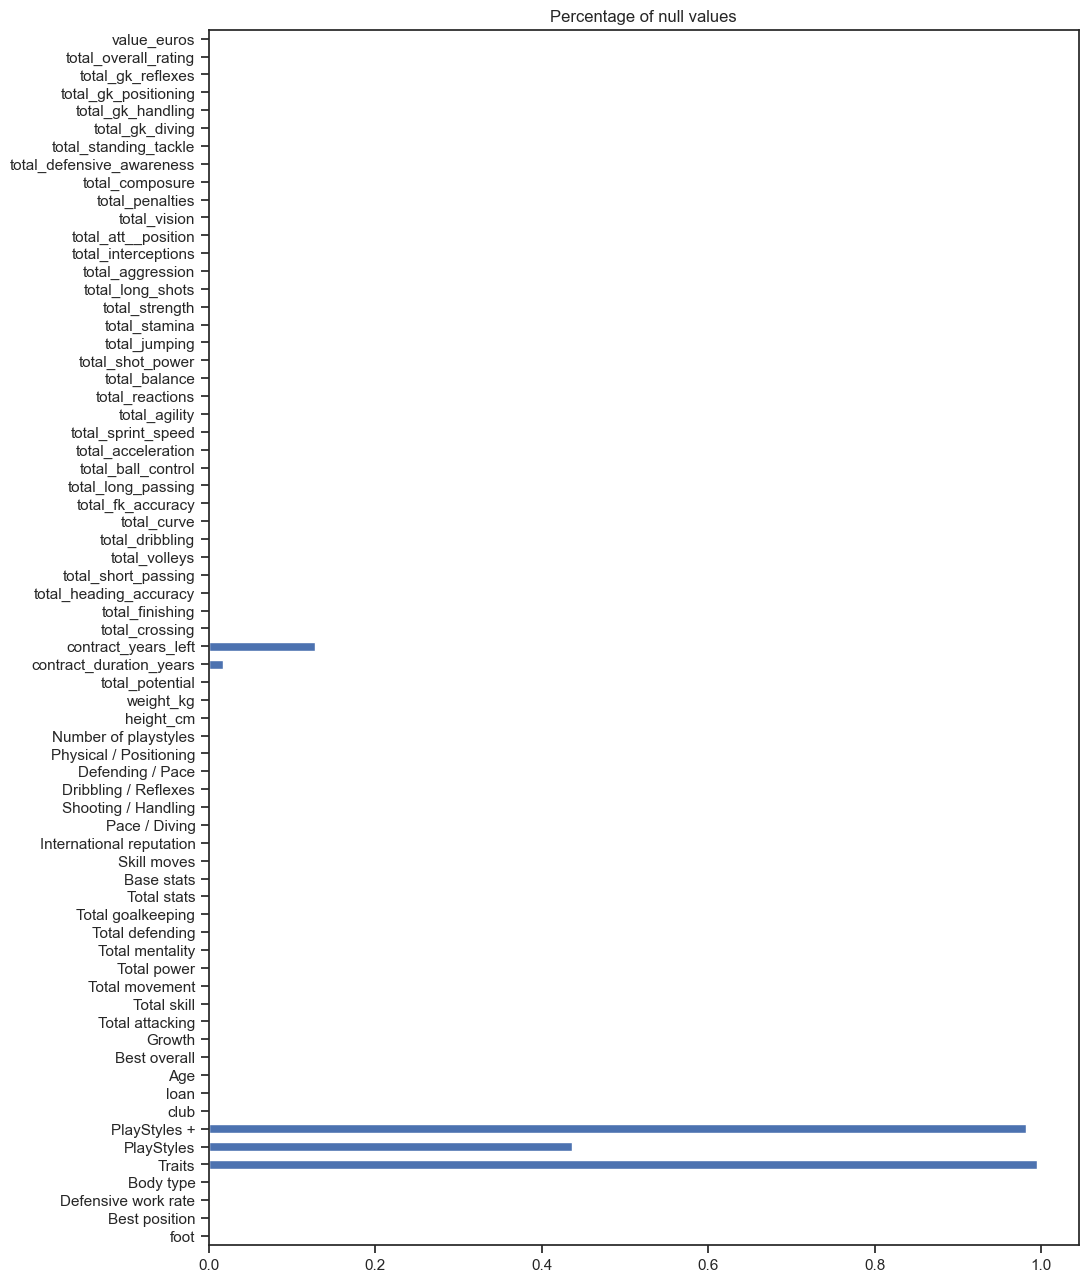

In [207]:
print(df.shape)
plt.figure(figsize=(10,15))
plt.title('Percentage of null values')
df.isna().mean().plot(kind='barh')

In [208]:
## Removing null values from contract_years_left column
df = df[~df['contract_years_left'].isna()]

## Exploratory Data Analysis

In [15]:
print(df[['Total stats','Age','Best overall','value_euros']].corr())


              Total stats       Age  Best overall  value_euros
Total stats      1.000000  0.350900      0.683441     0.434206
Age              0.350900  1.000000      0.511795     0.190106
Best overall     0.683441  0.511795      1.000000     0.675390
value_euros      0.434206  0.190106      0.675390     1.000000


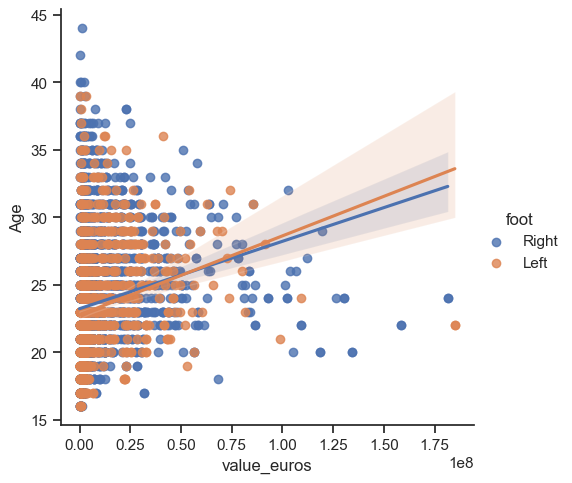

In [16]:
sns.lmplot(
    data = df, 
    x = 'value_euros',
    y = 'Age',
    hue = 'foot'
    )
plt.show()

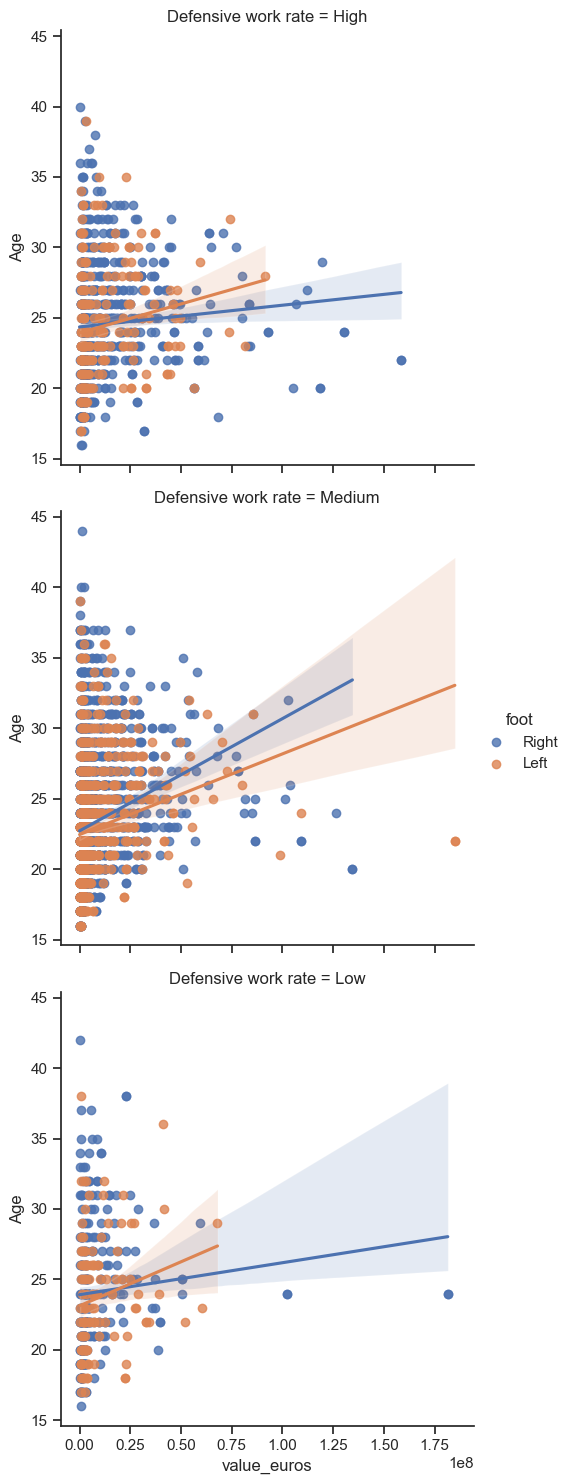

In [17]:
sns.lmplot(
    data = df, 
    x = 'value_euros',
    y = 'Age',
    col = 'Defensive work rate',
    hue = 'foot',
    col_wrap = 1
    )
plt.show()

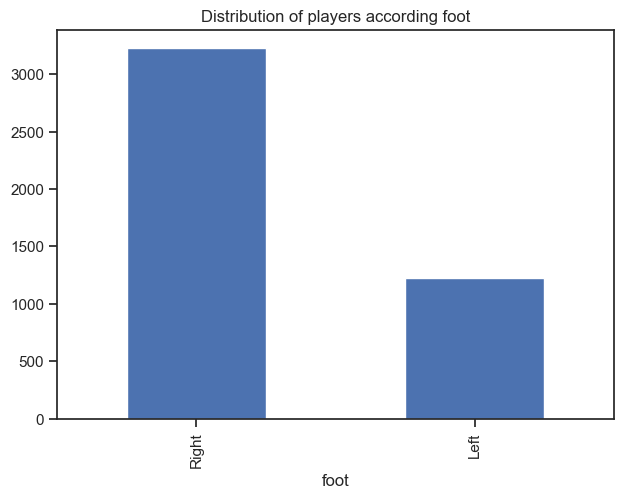

In [19]:
df['foot'].value_counts().plot(kind='bar')
plt.title('Distribution of players according foot')
plt.show()

## Causal inference

### Defining variables

To perform the analysis, I am going to use the variables about player performance. I will not include the variables about the wage, salary and release clause since there is a high risk of data leakage.

To identify the impact of a player having the left leg as the principal one, a `s-learner`, `t-learner`, `x-learner` and `r-learner` analysis would be performed and compared the results.

In [209]:
## Variables

y = df[TARGET].values.reshape(df.shape[0],)
x = df.loc[:,~df.columns.isin(['foot']+TARGET)][NUM_VARIABLES]
df['treatment'] = np.where(df['foot']=='Right','control','treatment')
treatment = df['treatment'].values

print(y.shape)
print(x.shape)

(4447,)
(4447, 58)


### SLearner

In [210]:
#### S Learner

model_tau = LGBMRegressor(importance_type='gain', random_state=123, verbose= -1)  

base_algo = LGBMRegressor(random_state=123, verbose = -1)


slearner = BaseSRegressor(base_algo, control_name='control')
te = slearner.estimate_ate(x, treatment, y)
print('Average treatment effect',te[0])

Average treatment effect 2245.5374807345997


In [211]:
slearner_tau = slearner.fit_predict(x, treatment, y)

#### Feature importance

In [212]:
importances = slearner.get_importance(X=x, 
                                    tau=slearner_tau,
                                    normalize=True, 
                                    method='auto', 
                                    features=NUM_VARIABLES)

pd.DataFrame(importances['treatment'], columns=['Importance Auto'])

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

,Importance Auto
total_att__position,0.237424
total_long_passing,0.170736
total_overall_rating,0.153581
Total defending,0.143374
total_shot_power,0.103543
total_potential,0.093774
total_dribbling,0.058692
total_finishing,0.012694
Best overall,0.012014
Total skill,0.004004


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

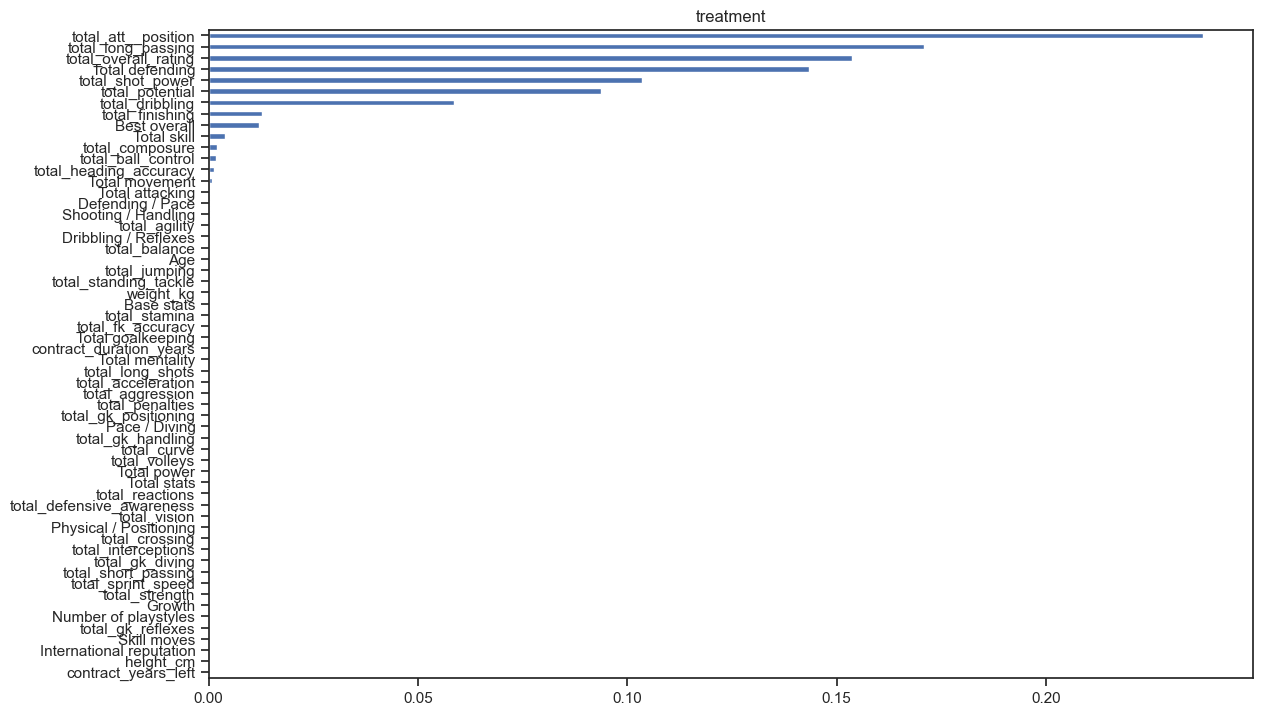

In [213]:
slearner.plot_importance(X=x, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=NUM_VARIABLES)

In [216]:
importances_permutation = slearner.get_importance(X=x, 
                                                    tau=slearner_tau, 
                                                    method='permutation', 
                                                    features=NUM_VARIABLES, 
                                                    random_state=42)

pd.DataFrame(importances_permutation['treatment'], columns=['Importance Permutation'])                                                    

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

,Importance Permutation
total_att__position,1.270687
total_long_passing,1.132531
total_overall_rating,0.987925
Total defending,0.323687
total_shot_power,0.221090
total_dribbling,0.219250
total_potential,0.122084
Dribbling / Reflexes,0.000863
total_ball_control,0.000342
Total movement,0.000300


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

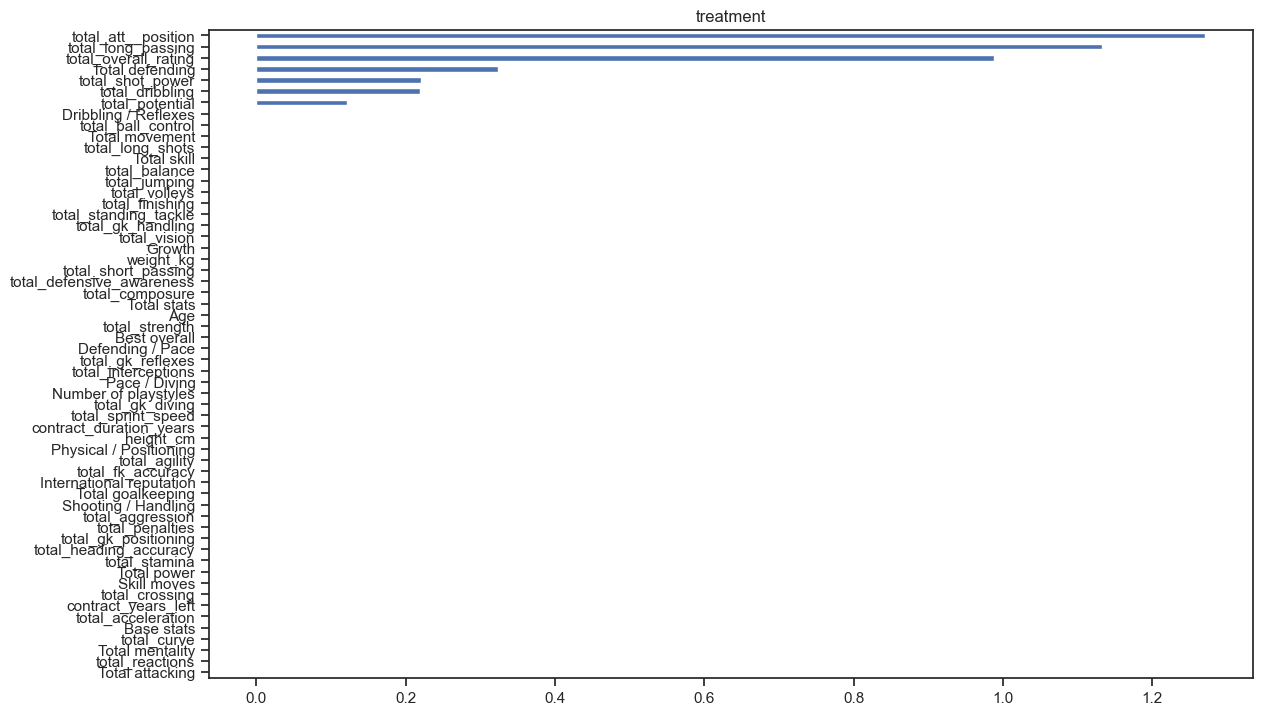

In [218]:
slearner.plot_importance(X=x, 
                         tau=slearner_tau, 
                         method='permutation', 
                         features=NUM_VARIABLES, 
                         random_state=42)

So far, with the single learner, the most important variable was `total_att_position`, in both methods auto and permutation, and something interesting is that the average treatment effect is positive, which could give some proof that the left players have a higher market value thant right players. Now, I will explore more splitting the dataset into train and test.

In [230]:
x_train, x_test, y_train, y_test = train_test_split(x, slearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(x_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=x_test, 
    y=y_test, 
    random_state=42).importances_mean
a = pd.Series(perm_imp_test, NUM_VARIABLES).sort_values(ascending=False)
df_a = pd.DataFrame(a, columns = ['Feature importance in test dataset'])
df_a


,Feature importance in test dataset
total_att__position,1.270687
total_long_passing,1.132531
total_overall_rating,0.987925
Total defending,0.323687
total_shot_power,0.221090
total_dribbling,0.219250
total_potential,0.122084
Dribbling / Reflexes,0.000863
total_ball_control,0.000342
Total movement,0.000300


Text(0.5, 1.0, 'Test Set Permutation Importances')

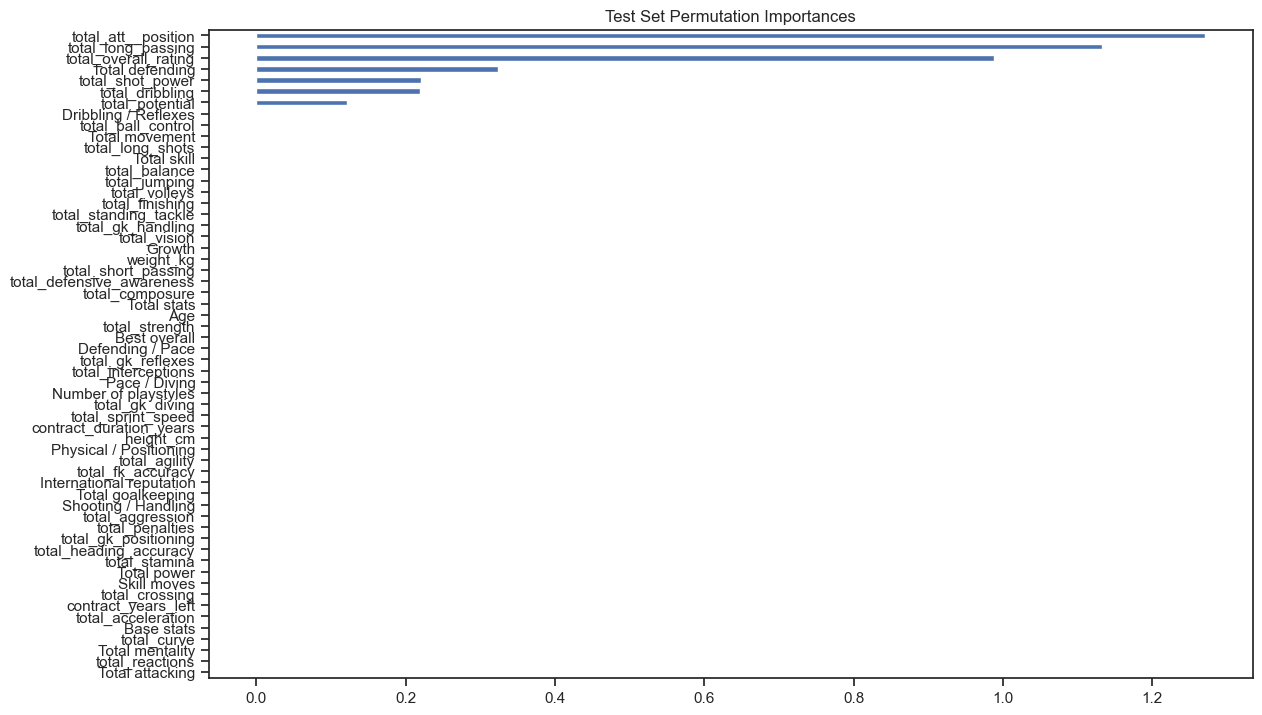

In [221]:
pd.Series(perm_imp_test, NUM_VARIABLES).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [231]:
perm_imp_train = permutation_importance(
    estimator=model_tau_fit, 
    X=x_train, 
    y=y_train, 
    random_state=42).importances_mean
a = pd.Series(perm_imp_train, NUM_VARIABLES).sort_values(ascending=False)
a_df = pd.DataFrame(a, columns = ['Feature importance in train dataset'])
a_df

,Feature importance in train dataset
total_att__position,1.185451
total_overall_rating,0.871847
total_long_passing,0.508706
total_potential,0.299576
Total defending,0.292120
total_shot_power,0.200297
total_dribbling,0.133910
total_reactions,0.000956
Dribbling / Reflexes,0.000731
Total movement,0.000472


Text(0.5, 1.0, 'Training Set Permutation Importances')

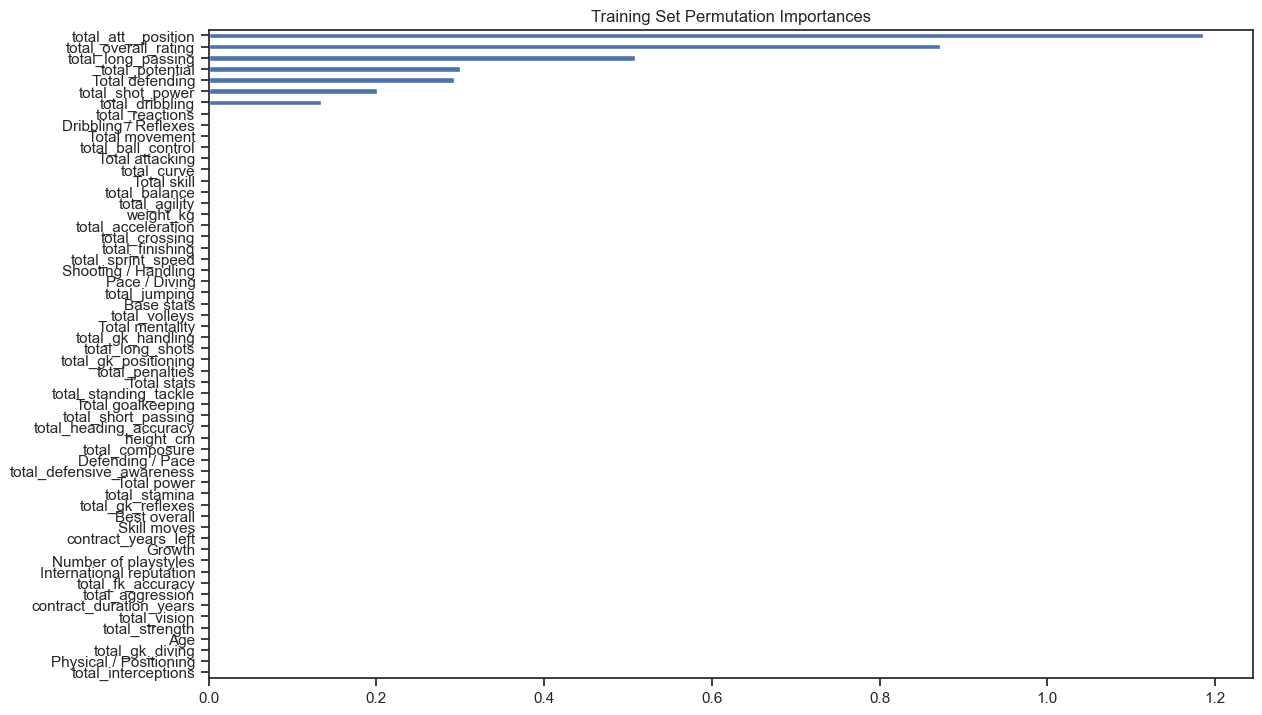

In [232]:
pd.Series(perm_imp_train, NUM_VARIABLES).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Training Set Permutation Importances')

One important insight is that the variable `total_att_position` remains as the most important one in both train and test datasets, which implies that the variable keeps its importance even in the test set.

In [238]:
shap_slearner = slearner.get_shap_values(X=x, tau=slearner_tau)
shap_slearner['treatment'].shape

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

(4447, 58)

In [244]:
df_shap = pd.DataFrame(np.mean(np.abs(shap_slearner['treatment']),axis=0), columns = ['Mean SHAP'])
df_shap['VARS'] = NUM_VARIABLES
df_shap

,Mean SHAP,VARS
0,8.158963,total_aggression
1,15.682393,weight_kg
2,50.205248,total_ball_control
3,17.567857,Total movement
4,5.189050,total_gk_positioning
5,7.735162,Growth
6,50.810361,Best overall
7,15.483383,total_agility
8,590.681563,total_shot_power
9,4.693228,total_crossing


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

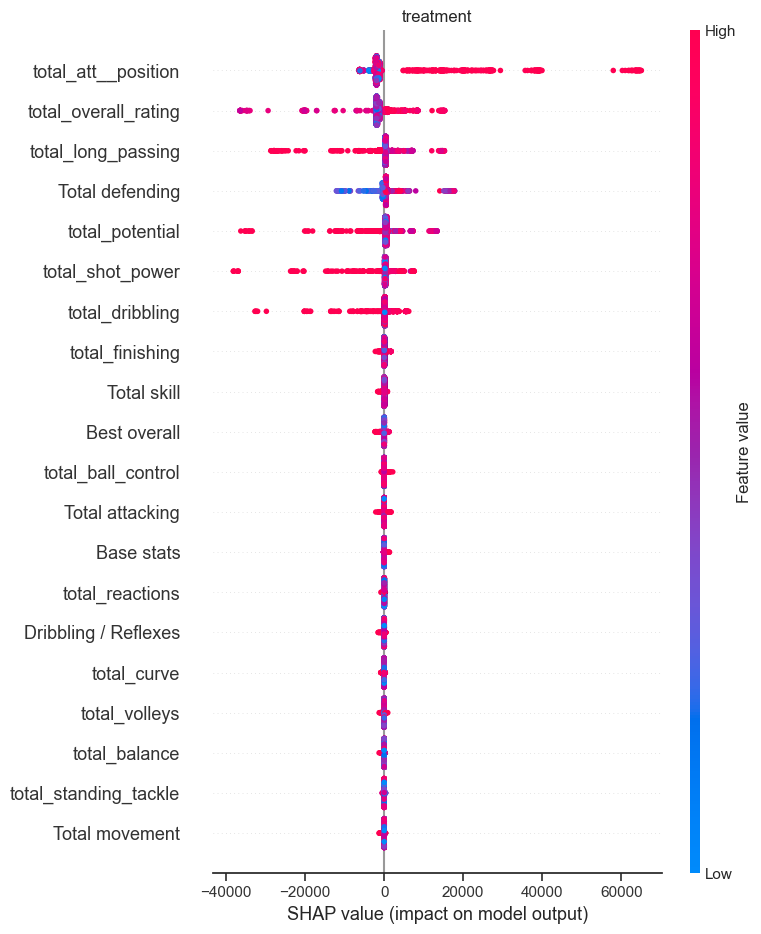

In [245]:
slearner.plot_shap_values(X=x, tau=slearner_tau, features=NUM_VARIABLES)

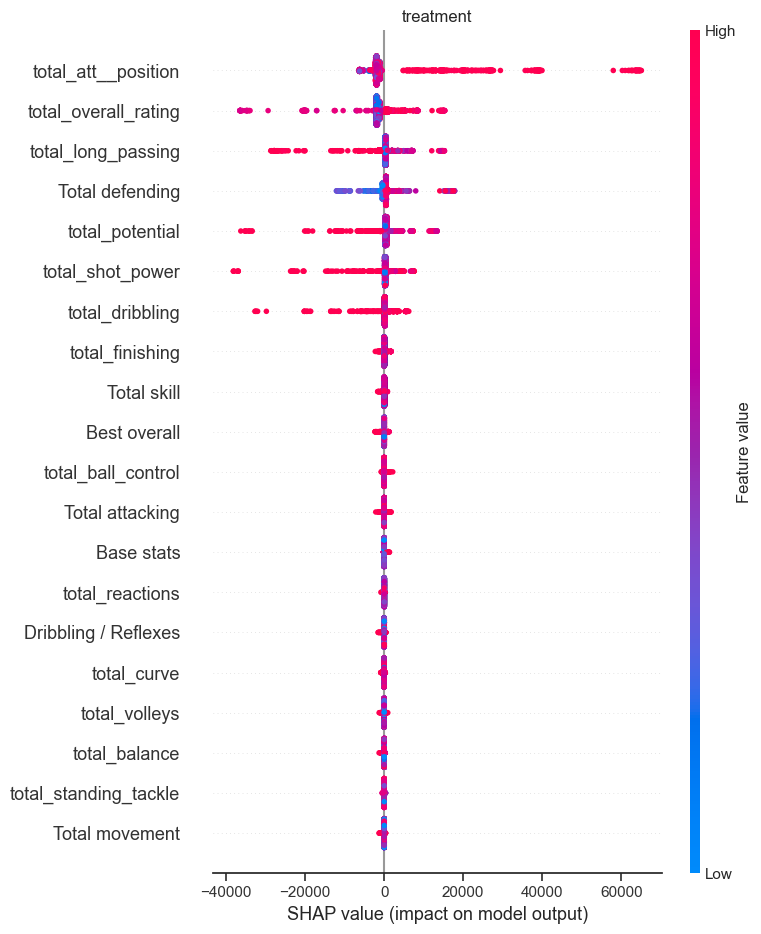

In [246]:
slearner.plot_shap_values(X=x,shap_dict=shap_slearner, features= NUM_VARIABLES)

Considering the first graph, with the model only, and considering the graph with the SHAP values, and the interesting part is that the variable `total_att_position` remains as the most important one, with the highest impact on the target variable.

In [260]:
x.columns

Index(['total_aggression', 'weight_kg', 'total_ball_control', 'Total movement',
       'total_gk_positioning', 'Growth', 'Best overall', 'total_agility',
       'total_shot_power', 'total_crossing', 'Dribbling / Reflexes',
       'total_att__position', 'total_standing_tackle',
       'contract_duration_years', 'Number of playstyles', 'total_fk_accuracy',
       'total_composure', 'total_volleys', 'total_heading_accuracy',
       'International reputation', 'total_stamina', 'total_reactions',
       'total_potential', 'Total defending', 'height_cm', 'total_dribbling',
       'total_vision', 'total_overall_rating', 'Shooting / Handling',
       'Physical / Positioning', 'Total goalkeeping', 'Skill moves',
       'total_curve', 'Defending / Pace', 'Pace / Diving',
       'total_acceleration', 'total_defensive_awareness', 'total_finishing',
       'total_strength', 'total_jumping', 'total_gk_handling',
       'total_sprint_speed', 'total_balance', 'Total power',
       'total_gk_reflexes',

SHAP value for total_agility


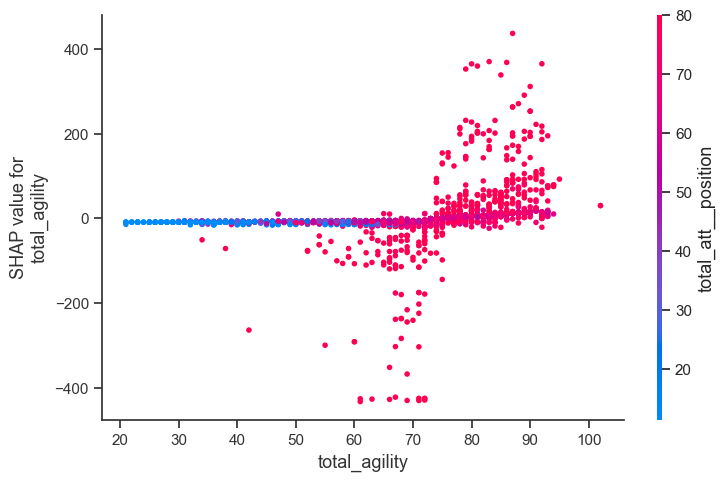

In [257]:
index = 7
variable_name = list(x.columns)[index]
print(f'SHAP value for {variable_name}')
slearner.plot_shap_dependence(treatment_group='treatment',
                              feature_idx=index,
                              X=x,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features = NUM_VARIABLES
                              )



In this graph, we can see the contribution of the variable `total agility` to the final prediction, and its change, also considering the variable `total_att_position`. We can see that with more agility, the contribution to the final prediction increases, and it corresponds also with higher values of `total_att_position`.

SHAP value for total_att__position


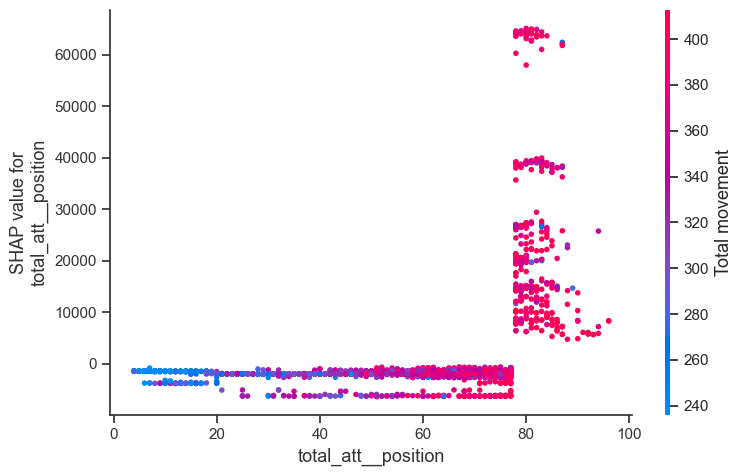

In [261]:
index = 11
variable_name = list(x.columns)[index]
print(f'SHAP value for {variable_name}')
slearner.plot_shap_dependence(treatment_group='treatment',
                              feature_idx=index,
                              X=x,
                              tau=slearner_tau,
                              interaction_idx='Total movement',
                              shap_dict=shap_slearner,
                              features = NUM_VARIABLES
                              )

This graph gives us a good understanding on how important is the variable `total_att_position` to the prediction. We can see that, from about 78 or higher in that variable, the contribution to the final predicion is consistently high. This could mean that the value of players from the attack zone is significantly higher than players from other zones, which could be true given the current situation of soccer players.

### T Learner

Now we are going to perform the analysis using a `t-learner`

In [274]:
tlearner = BaseTRegressor(LGBMRegressor(random_state=123, verbose = -1), control_name='control')
ate_mean, lb, ub = tlearner.estimate_ate(x, treatment, y)
print('Average treatment effect:', ate_mean[0])
print('Lower bound of average treatment effect:', lb[0])
print('Upper bound of average treatment effect:', ub[0])

Average treatment effect: 43397.48446235485
Lower bound of average treatment effect: -156150.6111543933
Upper bound of average treatment effect: 242945.580079103


In [275]:
tlearner_tau = tlearner.fit_predict(x, treatment, y)

In [276]:
tlearner.get_importance(X=x, 
                        tau=tlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=NUM_VARIABLES)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment': total_potential              0.439363
 Best overall                 0.071053
 Dribbling / Reflexes         0.063414
 Age                          0.043501
 Total movement               0.039324
 total_overall_rating         0.022555
 total_penalties              0.020896
 Total mentality              0.020531
 total_dribbling              0.019198
 total_aggression             0.015719
 total_reactions              0.014643
 total_sprint_speed           0.012779
 International reputation     0.012724
 Total power                  0.011924
 Total attacking              0.010476
 Total goalkeeping            0.010186
 total_acceleration           0.010063
 Total skill                  0.009833
 total_strength               0.008165
 total_att__position          0.008050
 total_fk_accuracy            0.007930
 Physical / Positioning       0.007753
 total_short_passing          0.006531
 Pace / Diving                0.006107
 total_stamina                0.005998
 total_long_

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

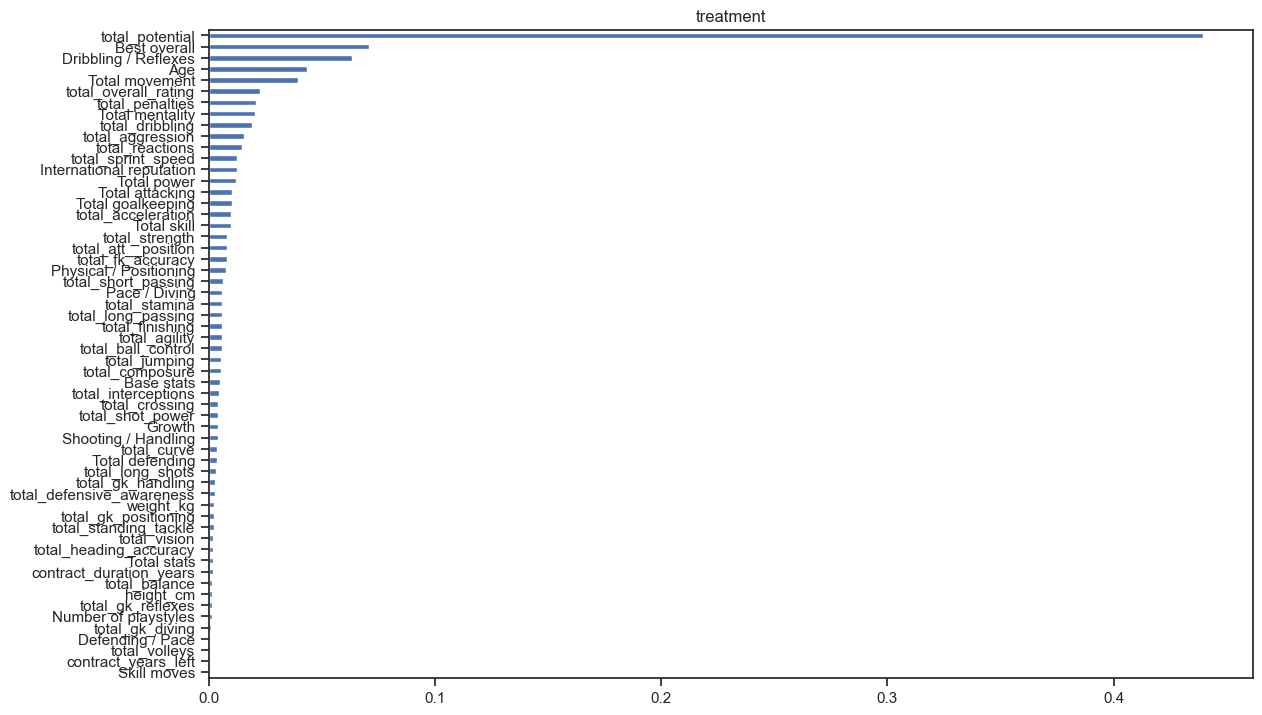

In [269]:
tlearner.plot_importance(X=x,                          tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=NUM_VARIABLES)

In [270]:
tlearner.get_importance(X=x, 
                        tau=tlearner_tau, 
                        method='permutation', 
                        features=NUM_VARIABLES, 
                        random_state=42)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment': total_potential              0.252746
 International reputation     0.187799
 Best overall                 0.136368
 total_composure              0.121319
 total_overall_rating         0.056437
 Total movement               0.044296
 Dribbling / Reflexes         0.041038
 Total mentality              0.031098
 total_dribbling              0.028515
 total_aggression             0.027003
 total_penalties              0.023904
 Total skill                  0.019440
 total_sprint_speed           0.016811
 total_acceleration           0.016623
 Age                          0.015248
 Total attacking              0.013261
 total_fk_accuracy            0.012697
 Physical / Positioning       0.009887
 total_strength               0.006831
 total_long_shots             0.006366
 total_shot_power             0.005899
 total_curve                  0.005310
 Total power                  0.004822
 total_short_passing          0.004232
 total_vision                 0.003870
 total_jumpi

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

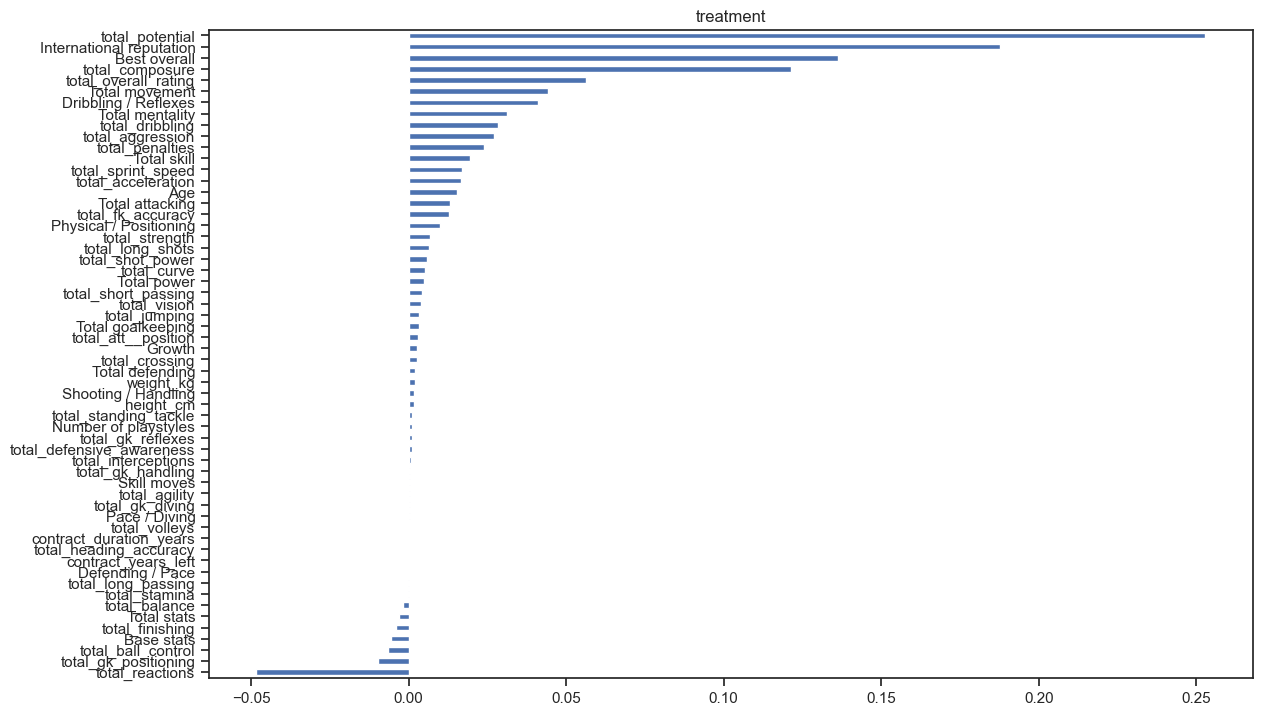

In [271]:
tlearner.plot_importance(X=x, 
                         tau=tlearner_tau, 
                         method='permutation', 
                         features=NUM_VARIABLES, 
                         random_state=42)

Using the `T-learner` technique, and getting importances using `auto` and `permutation` methods, the most important variable is `total_potential`, which differs from the `S-learner` technique. The `T-learner` technique uses two models, one for each treatment and shows the difference between treatment and control. Now, we are validate the feature importance using a split in the train and test datasets.

In [277]:
x_train, x_test, y_train, y_test = train_test_split(x, tlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(x_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=x_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, NUM_VARIABLES).sort_values(ascending=False)

total_potential              0.252746
International reputation     0.187799
Best overall                 0.136368
total_composure              0.121319
total_overall_rating         0.056437
Total movement               0.044296
Dribbling / Reflexes         0.041038
Total mentality              0.031098
total_dribbling              0.028515
total_aggression             0.027003
total_penalties              0.023904
Total skill                  0.019440
total_sprint_speed           0.016811
total_acceleration           0.016623
Age                          0.015248
Total attacking              0.013261
total_fk_accuracy            0.012697
Physical / Positioning       0.009887
total_strength               0.006831
total_long_shots             0.006366
total_shot_power             0.005899
total_curve                  0.005310
Total power                  0.004822
total_short_passing          0.004232
total_vision                 0.003870
total_jumping                0.003460
Total goalke

In [278]:
pd.Series(perm_imp_test, NUM_VARIABLES).sort_values(ascending=False)

total_potential              0.252746
International reputation     0.187799
Best overall                 0.136368
total_composure              0.121319
total_overall_rating         0.056437
Total movement               0.044296
Dribbling / Reflexes         0.041038
Total mentality              0.031098
total_dribbling              0.028515
total_aggression             0.027003
total_penalties              0.023904
Total skill                  0.019440
total_sprint_speed           0.016811
total_acceleration           0.016623
Age                          0.015248
Total attacking              0.013261
total_fk_accuracy            0.012697
Physical / Positioning       0.009887
total_strength               0.006831
total_long_shots             0.006366
total_shot_power             0.005899
total_curve                  0.005310
Total power                  0.004822
total_short_passing          0.004232
total_vision                 0.003870
total_jumping                0.003460
Total goalke

Text(0.5, 1.0, 'Test Set Permutation Importances')

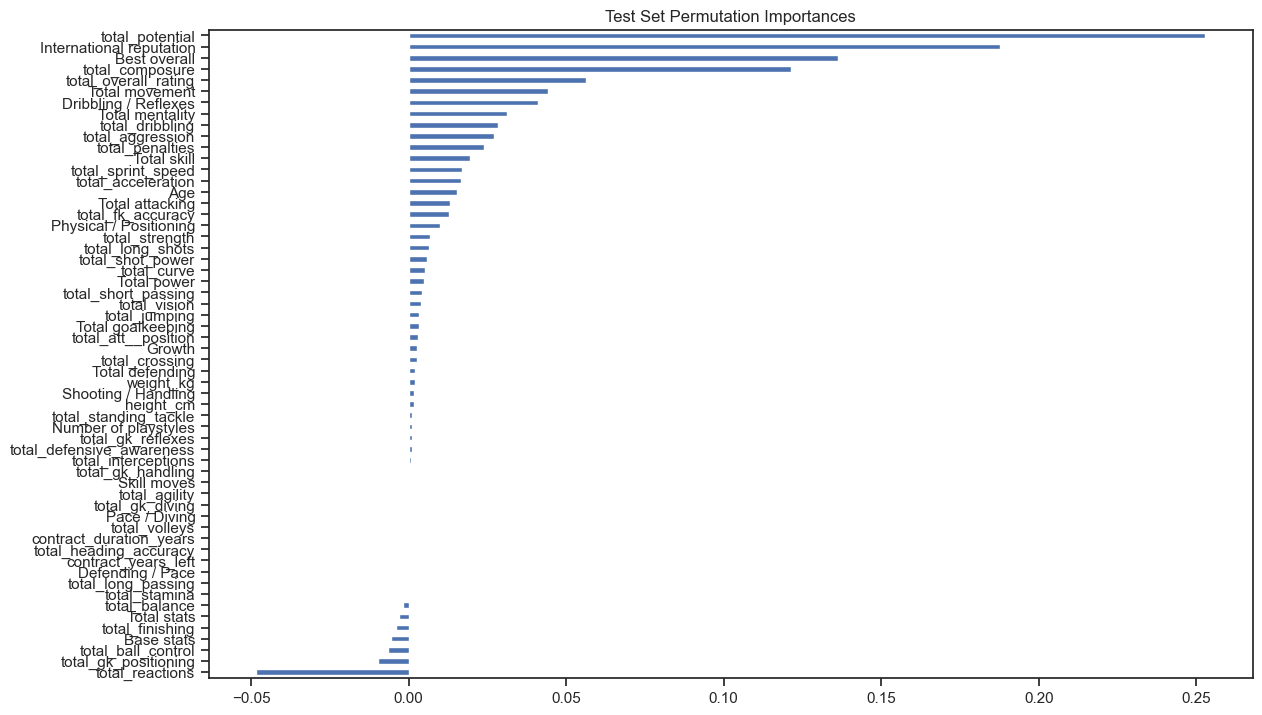

In [279]:
pd.Series(perm_imp_test, NUM_VARIABLES).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

total_potential              0.250442
Best overall                 0.169093
total_dribbling              0.096612
total_reactions              0.081450
total_overall_rating         0.077214
International reputation     0.071115
total_composure              0.048678
total_sprint_speed           0.042392
Total movement               0.037006
total_ball_control           0.027163
total_aggression             0.025111
Age                          0.022735
total_penalties              0.022196
Total mentality              0.020543
Dribbling / Reflexes         0.019656
Total skill                  0.016550
total_gk_positioning         0.016105
Total attacking              0.014661
total_finishing              0.011455
Shooting / Handling          0.011362
total_acceleration           0.010695
Base stats                   0.009448
total_att__position          0.009034
total_strength               0.008908
total_shot_power             0.008562
Physical / Positioning       0.008556
total_jumpin

Text(0.5, 1.0, 'Train Set Permutation Importances')

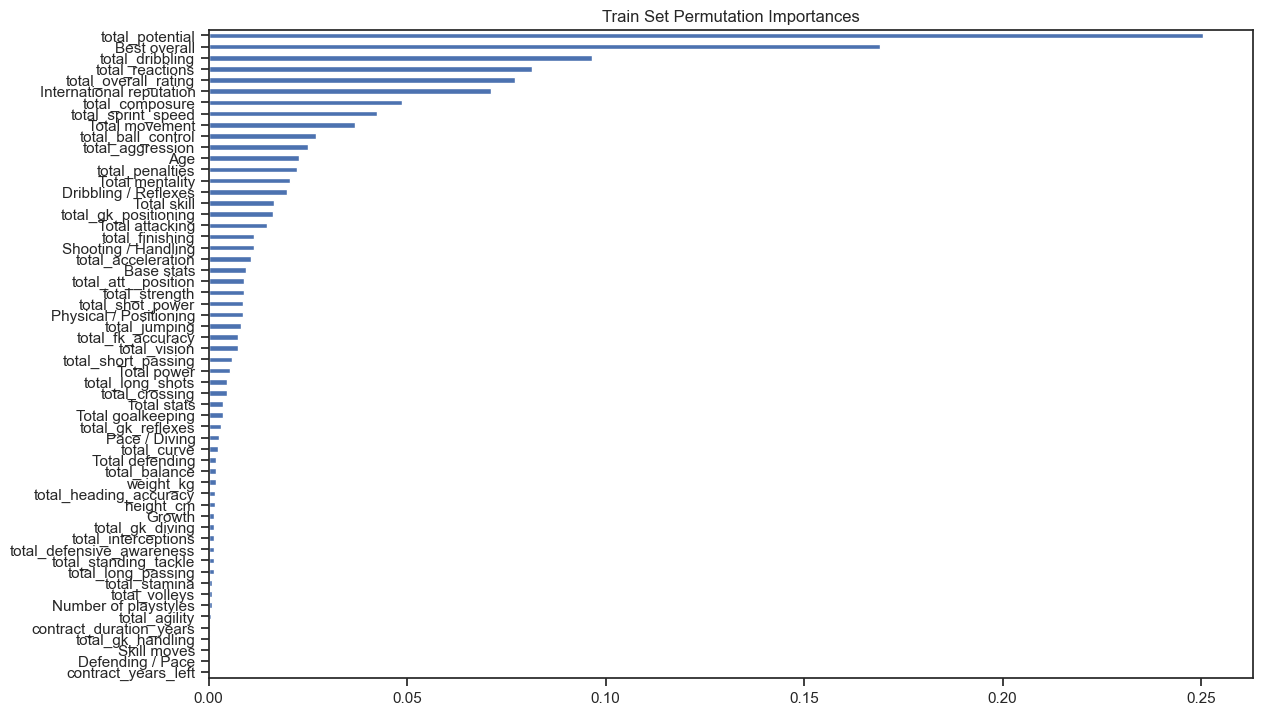

In [282]:
perm_imp_train = permutation_importance(
    estimator=model_tau_fit, 
    X=x_train, 
    y=y_train, 
    random_state=42).importances_mean
print(pd.Series(perm_imp_train, NUM_VARIABLES).sort_values(ascending=False))
pd.Series(perm_imp_train, NUM_VARIABLES).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Train Set Permutation Importances')

Analyzing the feature importance in train and test datasets, we can see that the variable `total_potential` remains as the most important variable, but the second one differs because test, the variable `international_reputation` is the second most important and in train set the variable `best overall` is the second most important.

Although the order seems to be different, the most important variables remains the same in both datasets, which is a good indicator of a consistent performance in the model. Now, we will explore the SHAP values.

#### SHAP Values

In [283]:
shap_tlearner = tlearner.get_shap_values(X=x, tau=tlearner_tau)
shap_tlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{'treatment': array([[ 1.73799642e+04, -1.43032331e+04,  1.51547193e+04, ...,
          4.73569251e+04, -3.94711395e+01,  2.98691030e+04],
        [ 5.71239441e+04, -1.21103284e+04, -1.54631598e+04, ...,
          1.82247995e+04,  2.16188982e+02,  2.34576002e+04],
        [-2.15952708e+05, -1.36573726e+04,  9.41578999e+04, ...,
         -8.23699368e+04, -1.19184013e+03, -5.76805869e+05],
        ...,
        [-3.21727854e+04, -6.60032103e+03, -1.98250233e+04, ...,
          4.47307146e+03,  2.99643845e+02,  1.54159964e+04],
        [-3.83149709e+04, -9.65768946e+03, -1.93712736e+04, ...,
          4.68065009e+03,  6.81142268e+02,  1.79303317e+04],
        [ 2.69265851e+04,  8.62757913e+03, -2.69197299e+04, ...,
          1.88808488e+04,  6.61753521e+03, -9.10608440e+02]])}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

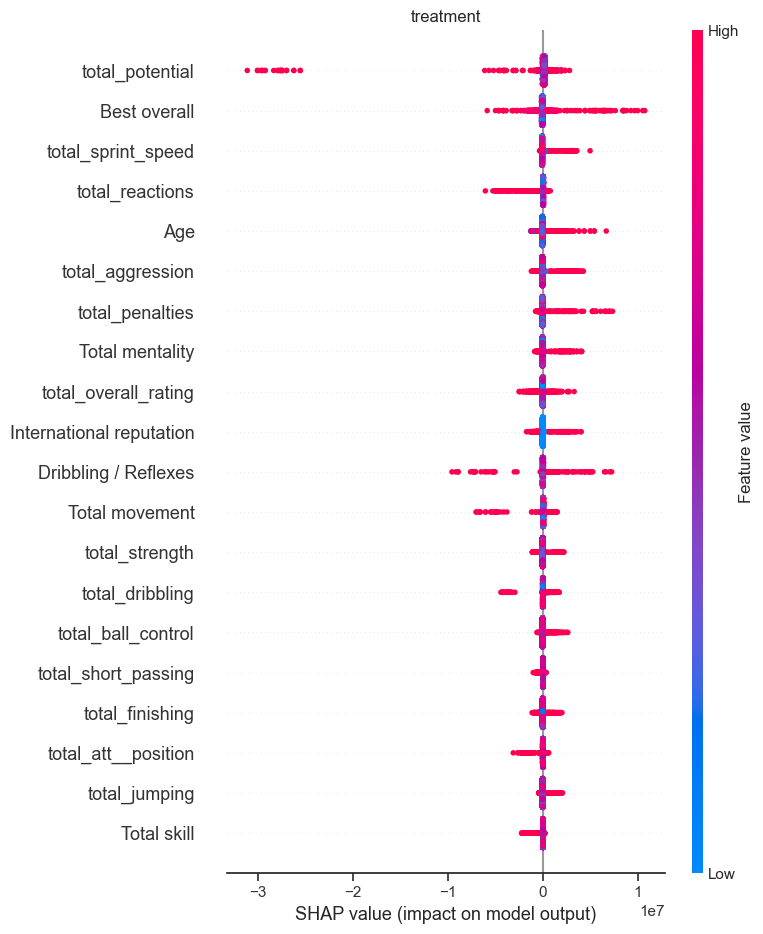

In [284]:
tlearner.plot_shap_values(X=x, tau=tlearner_tau, features=NUM_VARIABLES)

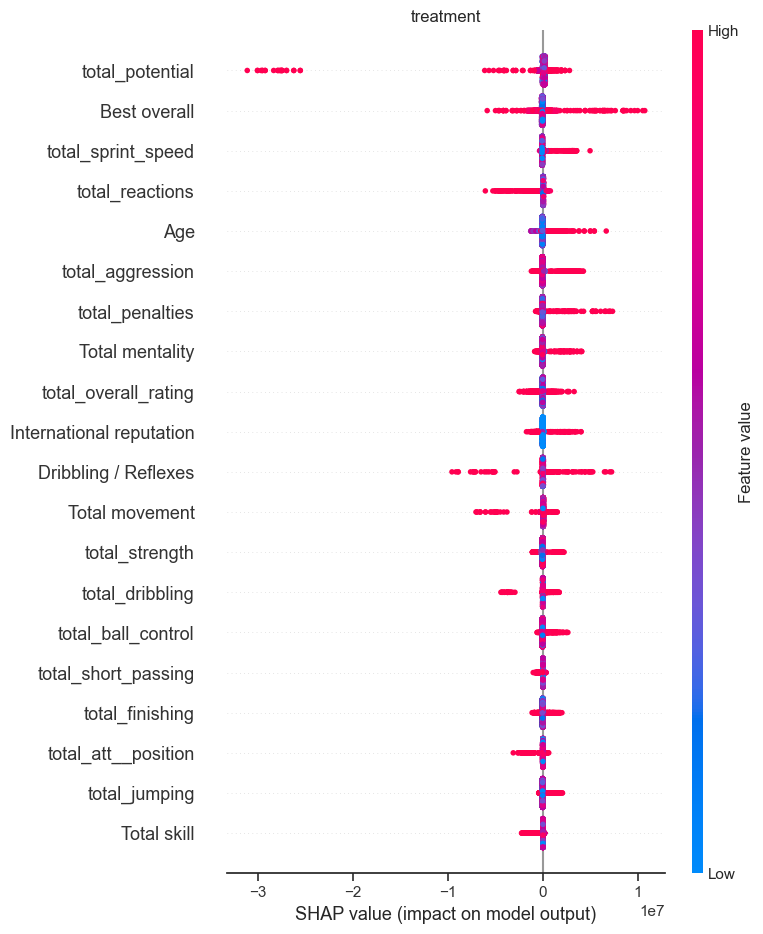

In [286]:
tlearner.plot_shap_values(X=x, shap_dict=shap_tlearner, features=NUM_VARIABLES)

In [288]:
x_train

,total_aggression,weight_kg,total_ball_control,Total movement,total_gk_positioning,Growth,Best overall,total_agility,total_shot_power,total_crossing,Dribbling / Reflexes,total_att__position,total_standing_tackle,contract_duration_years,Number of playstyles,total_fk_accuracy,total_composure,total_volleys,total_heading_accuracy,International reputation,total_stamina,total_reactions,total_potential,Total defending,height_cm,total_dribbling,total_vision,total_overall_rating,Shooting / Handling,Physical / Positioning,Total goalkeeping,Skill moves,total_curve,Defending / Pace,Pace / Diving,total_acceleration,total_defensive_awareness,total_finishing,total_strength,total_jumping,total_gk_handling,total_sprint_speed,total_balance,Total power,total_gk_reflexes,total_gk_diving,Base stats,Age,Total skill,total_long_passing,Total stats,Total mentality,total_penalties,total_long_shots,Total attacking,total_interceptions,contract_years_left,total_short_passing
225,72,78,78,382,14,7,82,73,58,60,77,66,82,5.0,2,31,85,41,68,3,82,78,86,241,179,76,64,79,47,80,48,3,44,80,78,79,83,41,82,84,6,78,74,352,14,6,429,22,299,70,1938,326,42,46,290,82,4.0,80
3773,35,70,58,300,12,10,59,51,56,29,56,52,19,4.0,0,39,50,44,56,1,52,52,67,41,182,57,47,57,56,53,51,2,38,19,68,65,12,59,58,74,8,70,62,295,7,10,297,20,234,42,1371,207,57,55,243,16,2.0,55
3888,63,70,72,286,10,12,66,48,55,35,56,42,68,6.0,0,41,53,32,43,1,48,56,77,197,170,47,62,65,41,48,43,2,36,65,52,58,64,34,47,59,8,54,79,226,6,5,318,19,257,64,1500,280,42,43,211,71,2.0,67
3718,65,79,66,306,5,17,61,65,61,44,63,52,58,3.0,0,41,47,47,56,1,64,61,76,164,181,62,53,59,51,62,56,2,49,54,57,61,51,48,59,61,9,53,66,293,14,15,342,20,280,62,1629,272,50,48,258,52,1.0,63
1710,61,61,70,419,11,8,72,90,60,67,73,64,67,4.0,3,46,68,32,49,1,73,67,79,197,168,71,65,71,60,58,56,3,65,64,84,87,66,64,49,62,9,82,93,306,14,14,405,21,318,66,1877,301,48,62,280,63,3.0,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5071,46,67,65,389,15,1,65,90,60,52,70,56,35,3.0,0,42,54,58,39,1,77,57,65,98,172,70,64,64,57,52,56,3,65,33,77,76,34,58,42,46,15,77,89,279,10,7,348,27,295,53,1618,231,40,54,270,25,1.0,63
480,79,75,83,374,10,0,84,70,82,85,79,76,83,13.0,2,77,84,57,61,3,85,85,84,234,176,77,85,84,72,78,54,3,84,79,69,70,80,69,75,74,12,68,81,391,13,14,462,31,404,83,2204,389,67,75,358,82,0.0,86
3403,63,72,60,308,8,20,62,57,59,59,59,50,56,5.0,0,60,56,45,49,1,58,54,77,156,188,60,50,57,57,58,47,2,53,51,72,75,47,57,55,60,14,70,52,292,9,9,355,19,293,60,1632,264,53,60,272,48,2.0,62
4219,27,82,24,164,70,5,68,24,50,11,67,7,12,4.0,0,13,39,8,10,1,23,58,73,29,186,12,33,68,69,70,341,1,14,25,69,30,6,5,45,46,69,18,34,172,67,69,366,24,86,23,951,93,17,8,66,9,2.0,32


SHAP value for total_potential


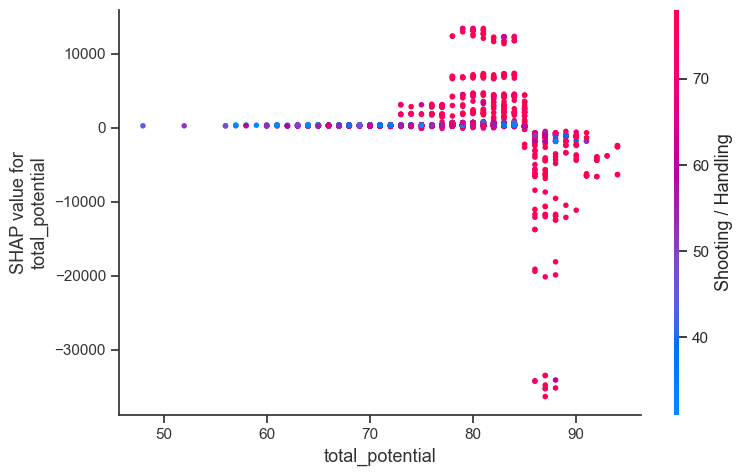

In [295]:
index = 22
variable_name = list(x.columns)[index]
print(f'SHAP value for {variable_name}')
tlearner.plot_shap_dependence(treatment_group='treatment',
                              feature_idx=index,
                              X=x,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features = NUM_VARIABLES
                              )



Analyzing the SHAP value, we can see that the `total potential` variable has a clear positive impact on the prediction until it gets about 84, from that value, the impact is negative, which is different of the results we got in the `s-learner` tecnique

## Conclusions

On this notebook, a `t-learner` and `s-learner` analysis were performed to identify if a soccer player with left as strong foot has a higher value market than a soccer player that has a right strong foot.

Using the `s-learner`. it showed a positive average treatment effect, which could mean that there is difference between the players with left and right strong foot. The most important variable is total attack position and showed that the predict value of the player increases as the attack skill increases, according to SHAP values. This could indicates that the differences between the two groups is bigger in attacker players.

Usint the `t-learner`, which is a more strong analysis using two models instead of one, it showed that the average treatment effect is also positive, which is related with the previous conclusion. Additionally, the importance of variable changes having the total potential as the most important one. Interestingly, it showed that if the potential reduces, the value increases. This could indicate that consolidated mature players are more expensive that young promises, and the consolidated players with left strong foot are more expensive (it could be convenient to exclude Lionel Messi of the analysis, of course).